<a href="https://colab.research.google.com/github/susana1mejia/Deep-Learning-Proyect/blob/main/03_Preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pre-procesado ###

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast
from google.colab import files
from sklearn import preprocessing
import pickle

In [2]:
data = pd.read_csv('dataset.csv', delimiter = ",")
data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.252016,4009.179857,4289.183762,4148.152134,4350.206818,4586.192335,4096.912112,4641.068253,4222.047068,4238.504085,4211.262674,4280.509561,4635.972757,4393.821298,0.0
1,4329.276576,4009.545851,4289.846850,4149.876997,4348.948891,4585.743231,4095.969803,4636.083925,4218.658842,4237.629679,4211.043057,4280.843897,4635.782573,4393.707079,0.0
2,4329.159169,4009.806795,4290.179692,4151.312677,4347.709375,4585.291374,4095.038011,4631.297467,4215.329742,4236.671689,4210.680948,4280.980911,4635.374559,4393.398360,0.0
3,4328.778394,4009.867157,4289.906759,4152.195493,4346.505619,4584.844082,4094.130817,4626.895725,4212.129647,4235.577566,4210.075214,4280.766903,4634.586658,4392.737855,0.0
4,4328.044111,4009.656002,4288.829299,4152.322706,4345.356010,4584.412957,4093.264984,4623.032657,4209.126745,4234.316706,4209.161587,4280.097206,4633.308796,4391.620422,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14299,4283.390677,3993.751719,4250.790123,4117.606639,4333.696587,4615.322201,4079.298329,4631.301166,4205.344250,4223.287428,4172.161819,4270.605627,4597.698679,4343.395492,1.0
14300,4284.007103,3994.371283,4252.408610,4118.006068,4333.510705,4615.571216,4080.885936,4632.827209,4206.714920,4223.697055,4170.925006,4270.959829,4597.405059,4344.680772,1.0
14301,4285.086297,3995.376535,4254.677169,4118.893366,4333.397851,4615.896425,4083.063010,4634.645836,4208.418492,4224.384932,4169.693744,4271.711624,4597.311131,4346.507739,1.0
14302,4286.482753,3996.635858,4257.390748,4120.106515,4333.337273,4616.259804,4085.666276,4636.646824,4210.349296,4225.294850,4168.502346,4272.774026,4597.394210,4348.706258,1.0


In [3]:
X = data.values[:,0:14].astype(np.float32)
Y = data.values[:,14].astype(int)
print(X.shape, Y.shape)

(14304, 14) (14304,)


In [4]:
X

array([[4329.252 , 4009.18  , 4289.1836, ..., 4280.51  , 4635.9727,
        4393.8213],
       [4329.2764, 4009.546 , 4289.8467, ..., 4280.8438, 4635.7827,
        4393.707 ],
       [4329.159 , 4009.807 , 4290.1797, ..., 4280.981 , 4635.3745,
        4393.3984],
       ...,
       [4285.0864, 3995.3765, 4254.6772, ..., 4271.7114, 4597.311 ,
        4346.508 ],
       [4286.483 , 3996.6357, 4257.3906, ..., 4272.774 , 4597.394 ,
        4348.706 ],
       [4288.016 , 3997.9895, 4260.2993, ..., 4274.021 , 4597.604 ,
        4351.0674]], dtype=float32)

In [5]:
X.shape

(14304, 14)

## Organización de los datos ##

De acuerdo con el objetivo de modelado, se deben crear las estructuras necesarias para la predicción:

**X debe tener 3 dimensiones**: una con el recorte de los datos, otra con las épocas creadas debido al overlapping y otra resultante de los 14 canales.

**Y debe ser un vector** con la misma longitud de las épocas, que contiene el porcentaje de ojos cerrados.

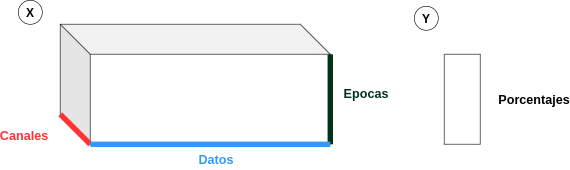

In [6]:
def chunk_data(data, window_size, overlap_size=0, flatten_inside_window=True):
    # Pasar la copia!
    # Adaptado de https://gist.github.com/mattjj/5213172
    assert data.ndim == 1 or data.ndim == 2
    if data.ndim == 1:
        data = data.reshape((-1, 1))

    # get the number of overlapping windows that fit into the data
    num_windows = (data.shape[0] - window_size) // (window_size - overlap_size) + 1
    overhang = data.shape[0] - (num_windows*window_size - (num_windows-1)*overlap_size)

    # if there's overhang, need an extra window and a -1 pad on the data
    if overhang != 0:
        num_windows += 1
        newdata = np.ones((num_windows*window_size - (num_windows-1)*overlap_size, data.shape[1]))*-1
        newdata[:data.shape[0]] = data
        data = newdata

    sz = data.dtype.itemsize
    ret = ast(
            data,
            shape=(num_windows, window_size*data.shape[1]),
            strides=((window_size-overlap_size)*data.shape[1]*sz, sz)
            )

    if flatten_inside_window:
        return ret
    else:
        return ret.reshape((num_windows, -1, data.shape[1]))


def calculate_closed_percent(target, epoc_len, overlap):
    y_procesada = chunk_data(np.copy(target), epoc_len, overlap)
    y_salida = []
    for epoc in y_procesada:
        y_salida.append(np.count_nonzero(epoc == 1)/epoc_len)
    return np.array(y_salida)


def reshaping(data, epoc_len, overlap):
    data = data.T
    # dimensiones: num canales - num epocas - tamaño de las epocas
    new_array = []
    for canal in data:
        chanel_in_epochs = chunk_data(np.copy(canal), epoc_len, overlap)

        new_array.append(chanel_in_epochs)

    new_array = np.array(new_array)
    new_array = np.transpose(new_array,(1, 0, 2))
    return new_array

In [7]:
structure_data_3D = reshaping(X, 298, 0)

In [8]:
structure_data_3D = reshaping(X, 200, 100)
  
print(structure_data_3D.shape)
structure_data_3D[-1]

(143, 14, 200)


array([[ 4.28883154e+03,  4.28890527e+03,  4.28899463e+03, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 4.02423218e+03,  4.02383447e+03,  4.02364526e+03, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 4.26521484e+03,  4.26483643e+03,  4.26399561e+03, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       ...,
       [ 4.28179688e+03,  4.28163086e+03,  4.28093311e+03, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 4.60142334e+03,  4.60167871e+03,  4.60204688e+03, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 4.35006055e+03,  4.34983398e+03,  4.34957422e+03, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]])

Los datos de cada uno de los canales se encuentran en el orden de los 4000 uV, por lo que se normalizan para evitar una saturación de las neuronas.

In [9]:
structure_data_3D = structure_data_3D / structure_data_3D.max()
structure_data_3D

array([[[ 9.18648169e-01,  9.18653350e-01,  9.18628483e-01, ...,
          9.08616851e-01,  9.08441437e-01,  9.08285606e-01],
        [ 8.50730298e-01,  8.50807954e-01,  8.50863335e-01, ...,
          8.36046788e-01,  8.35731810e-01,  8.35477859e-01],
        [ 9.10145840e-01,  9.10286544e-01,  9.10357207e-01, ...,
          9.01025263e-01,  9.01037697e-01,  9.01061423e-01],
        ...,
        [ 9.08305292e-01,  9.08376162e-01,  9.08405277e-01, ...,
          9.12586400e-01,  9.12548582e-01,  9.12529518e-01],
        [ 9.83732949e-01,  9.83692645e-01,  9.83606026e-01, ...,
          9.87555786e-01,  9.87358199e-01,  9.87158955e-01],
        [ 9.32349497e-01,  9.32325252e-01,  9.32259770e-01, ...,
          9.26124437e-01,  9.25961353e-01,  9.25802932e-01]],

       [[ 9.14373796e-01,  9.14559570e-01,  9.14674786e-01, ...,
          9.19510006e-01,  9.19156382e-01,  9.18921392e-01],
        [ 8.50527738e-01,  8.50410709e-01,  8.50267467e-01, ...,
          8.46280718e-01,  8.46011951e

In [10]:
structure_data_target = calculate_closed_percent(Y, 200, 100)
structure_data_target.shape

(143,)

In [11]:
with open('structure_data_3D.s', 'wb') as file:
  pickle.dump(structure_data_3D, file)

with open('structure_data_target.s', 'wb') as file:
  pickle.dump(structure_data_target, file)

## Feature engineering ##



In [11]:
mean_structure = np.mean(structure_data_3D, axis = 1)
std_structure = np.std(structure_data_3D, axis = 1)
max_structure = np.max(structure_data_3D, axis = 1)
min_structure = np.min(structure_data_3D, axis = 1)

feature_structure = np.array([mean_structure, std_structure, max_structure, min_structure])
feature_structure = np.transpose(feature_structure,(1, 0, 2))
print(feature_structure.shape)

(143, 4, 200)


In [12]:
with open('feature_structure.s', 'wb') as file:
  pickle.dump(feature_structure, file)